# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 2

**Author 1 (sciper):** Linda Delacombaz (288415)  
**Author 2 (sciper):** Chiara Maria Matti (350647)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [5]:
import platform
print(platform.system())
if platform.system() == "Darwin":
    %pip install torch==1.8.1 torchvision==0.9.1
else:
    # %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
    %pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html

Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.htmlNote: you may need to restart the kernel to use updated packages.

  Using cached https://download.pytorch.org/whl/cu113/torch-1.11.0%2Bcu113-cp310-cp310-win_amd64.whl (2186.0 MB)
     ---------------------------------------- 0.0/5.4 MB ? eta -:--:--
     ---- ----------------------------------- 0.6/5.4 MB 18.9 MB/s eta 0:00:01
     -------- ------------------------------- 1.2/5.4 MB 12.5 MB/s eta 0:00:01
     ----------- ---------------------------- 1.5/5.4 MB 12.3 MB/s eta 0:00:01
     --------------- ------------------------ 2.0/5.4 MB 11.7 MB/s eta 0:00:01
     ------------------ --------------------- 2.5/5.4 MB 11.6 MB/s eta 0:00:01
     ---------------------- ----------------- 3.0/5.4 MB 11.2 MB/s eta 0:00:01
     ------------------------- -------------- 3.5/5.4 MB 11.1 MB/s eta 0:00:01
     ----------------------------- ---------- 4.0/5.4 MB 11.0 MB/s eta 0:00:01
     --------------------------------- --

In [45]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [7]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

In [8]:
train_features.shape

torch.Size([878, 768])

In [9]:
train_labels.shape

(878,)

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

**Discussion**

Mahalonobis distance is the distance between a point and a distribution.

So, What is the effect of dividing by the covariance? If the variables in your dataset are strongly correlated, then, the covariance will be high. Dividing by a large covariance will effectively reduce the distance. Likewise, if the X’s are not correlated, then the covariance is not high and the distance is not reduced much.

x-m is the distance between vector and the mean.

x training features, m is the mean of the training features.

In [10]:
from sklearn.covariance import LedoitWolf

### Task 1
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - torch.mean(data, dim=0)
    if not cov:
        cov = LedoitWolf().fit(data).covariance_
    cov = torch.from_numpy(cov)
    inv_covmat = torch.inverse(cov)
    left_term = torch.mm(x_minus_mu, inv_covmat)
    mahal = torch.sqrt(torch.mm(left_term, x_minus_mu.T))
    return mahal.diagonal()

In [11]:
train_features_tumor = train_features[train_labels == 0]
train_features_stroma = train_features[train_labels == 1]

In [13]:
class MahalanobisClassifier:

    def __init__(self, train_features, train_labels):
        self.train_features_tumor = train_features[train_labels == 0]
        self.train_features_stroma = train_features[train_labels == 1]

    def predict_proba(self, test_features):
        pos_neg_dists = [(p,n) for p,n in zip(mahalanobis(test_features, self.train_features_stroma), mahalanobis(test_features, self.train_features_tumor))]
        prob = torch.tensor([(1-n/(p+n), 1-p/(p+n)) for p,n in pos_neg_dists])
        return prob
    
    def predict(self, test_features):
        prob = torch.tensor([torch.argmax(row) for row in self.predict_proba(test_features)])
        return prob

classifier = MahalanobisClassifier(train_features, train_labels)

In [14]:
pred_proba = classifier.predict_proba(test_features)
pred_class = classifier.predict(test_features)

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [17]:
### Task 2
from sklearn.metrics import accuracy_score
#Compute accuracy
accuracy = accuracy_score(test_labels, pred_class)

print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.98


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [19]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:**
TBD

Since the Mahalanobis distance is the distance between a point and a distribution, then the minimum distance means that it represents a low score for In-Distribution (close to the distribution). On the contrary, a point that is far from the distribution, will have higher Mahalanobis distance, thus greater chance to be an OoD.

Therefore, the minimum Mahalanobis distance is a good measure for creating a OoD score.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [20]:
### Task 2

# Compute the minimum Mahalanobis distance for every test examples with respect to the training data
pos_neg_dists = [(p,n) for p,n in zip(mahalanobis(test_features_w_ood, train_features_stroma), mahalanobis(test_features_w_ood, train_features_tumor))]

# Take the minimum distance
min_dists = torch.tensor([min(p,n) for p,n in pos_neg_dists])

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

TUMOR: 32.92
STROMA: 36.06
OoD: 53.75


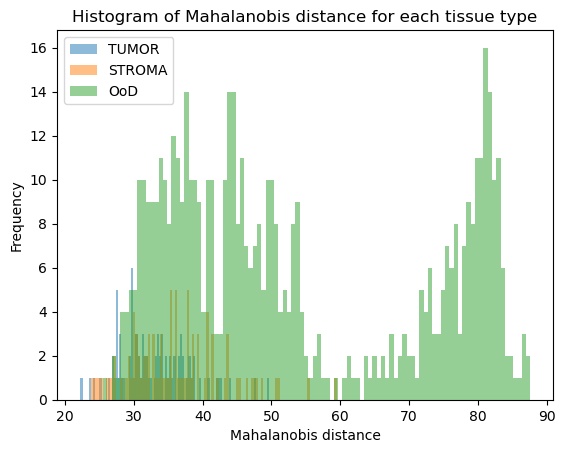

In [21]:
import matplotlib.pyplot as plt
#Show the difference between TUMOR, STROMA and OoD tissues
print("TUMOR: {:.2f}".format(torch.mean(min_dists[test_labels_w_ood == 0])))
print("STROMA: {:.2f}".format(torch.mean(min_dists[test_labels_w_ood == 1])))
print("OoD: {:.2f}".format(torch.mean(min_dists[test_labels_w_ood == -1])))

# Plot the histogram for each tissue type
plt.hist(min_dists[test_labels_w_ood == 0], bins=100, alpha=0.5, label="TUMOR")
plt.hist(min_dists[test_labels_w_ood == 1], bins=100, alpha=0.5, label="STROMA")
plt.hist(min_dists[test_labels_w_ood == -1], bins=100, alpha=0.5, label="OoD")
plt.legend()
plt.xlabel("Mahalanobis distance")
plt.ylabel("Frequency")
plt.title("Histogram of Mahalanobis distance for each tissue type")
plt.show()


**Observations:**

The OoD tissue types seems to populate the TUMOR and STROMA tissue type. It seems difficult to filter all of the OoD out without filtering out any TUMOR and STROMA out.

However, we can effectively observe that the OoD have, on average, higher distance than the TUMOR and STROMA. (Further away from the distributions)

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [22]:
### Task 4

# Threshold for the OoD class such that 95% of the OoD examples are filtered out
threshold = torch.quantile(min_dists[test_labels_w_ood == -1], 0.05)

threshold

tensor(30.7695)

In [30]:
# Filter out the OoD examples
stroma_features = test_features_w_ood[test_labels_w_ood == 1]
tumor_features = test_features_w_ood[test_labels_w_ood == 0]

filtered_stroma_features = stroma_features[min_dists[test_labels_w_ood == 1] < threshold]
filtered_tumor_features = tumor_features[min_dists[test_labels_w_ood == 0] < threshold]

# percentage of tumor and stroma features that are filtered out
print("Percentage of tumor features filtered out: {:.2f}".format(100*(tumor_features.shape[0] - filtered_tumor_features.shape[0]) / tumor_features.shape[0]), "%")
print("Percentage of stroma features filtered out: {:.2f}".format(100*(stroma_features.shape[0] - filtered_stroma_features.shape[0]) / stroma_features.shape[0]), "%")

Percentage of tumor features filtered out: 61.29 %
Percentage of stroma features filtered out: 74.19 %


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [31]:
### Task 5
# Compute the prediction for each test example
pred_class = classifier.predict(test_features_w_ood)

# Assign prediction -1 to filtered out OoD examples
pred_class_w_ood = pred_class.clone()
pred_class_w_ood[min_dists > threshold] = -1

# Compute accuracy
accuracy_w_ood = accuracy_score(test_labels_w_ood, pred_class_w_ood)

print("Accuracy: {:.2f}".format(accuracy_w_ood))

Accuracy: 0.79


In [32]:
# Decrease in accuracy compared to the previous task
print("Decrease in accuracy: {:.2f}".format(100*(accuracy - accuracy_w_ood) / accuracy), "%")

Decrease in accuracy: 18.96 %


The accuracy is lower than the previous task, but still is close to 80%, which is not too mediocre.

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

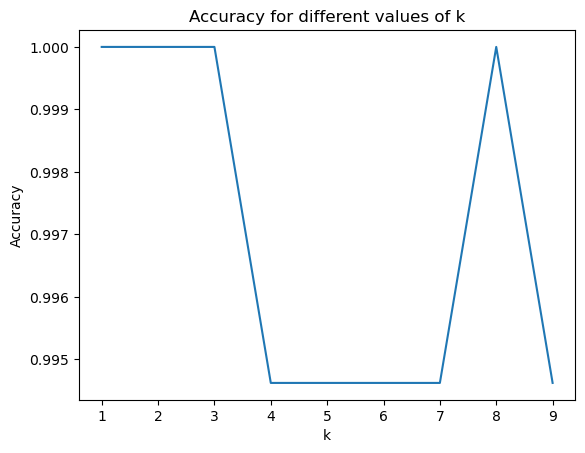

In [34]:
### Task 1

# Classify the test features using k-NN classifier
from sklearn.neighbors import KNeighborsClassifier

# Compare the knn with different values of k and plot the accuracy
accuracies = []
for k in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features, train_labels)
    pred_class = knn.predict(test_features)

    accuracies.append(accuracy_score(test_labels, pred_class))

plt.plot(range(1,10), accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy for different values of k")
plt.show()

In [35]:
#Set a seed for reproducibility
torch.manual_seed(0)

# Choose the optimal k
k = 3

# Train the classifier with the optimal k
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_features, train_labels)

# Compute the accuracy
pred_class_knn = knn.predict(test_features)
accuracy = accuracy_score(test_labels, pred_class_knn)

print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 1.00


## Is this not weird to have accuracy = 1 ???

**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

TUMOR: 44.96
STROMA: 42.39
OoD: 58.06


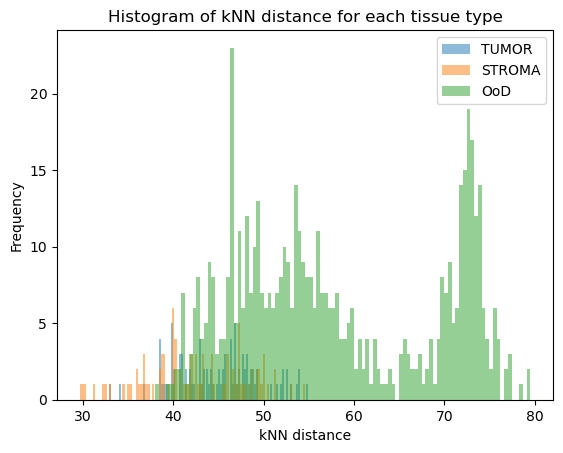

In [36]:
### Task 2

# kNN distance for each test example to create a OoD score
knn_dist, _ = knn.kneighbors(test_features_w_ood)

knn_dist = torch.tensor(knn_dist)

# OoD score for kNN distance
ood_score = torch.tensor([torch.mean(row) for row in knn_dist])

# Difference between TUMOR, STROMA and OoD tissues
print("TUMOR: {:.2f}".format(torch.mean(ood_score[test_labels_w_ood == 0])))
print("STROMA: {:.2f}".format(torch.mean(ood_score[test_labels_w_ood == 1])))
print("OoD: {:.2f}".format(torch.mean(ood_score[test_labels_w_ood == -1])))

# Histogram plot for each tissue type
plt.hist(ood_score[test_labels_w_ood == 0], bins=100, alpha=0.5, label="TUMOR")
plt.hist(ood_score[test_labels_w_ood == 1], bins=100, alpha=0.5, label="STROMA")
plt.hist(ood_score[test_labels_w_ood == -1], bins=100, alpha=0.5, label="OoD")
plt.legend()
plt.xlabel("kNN distance")
plt.ylabel("Frequency")
plt.title("Histogram of kNN distance for each tissue type")
plt.show()


In [37]:
#Threshold to filter out 95% of the OoD examples
threshold_knn = torch.quantile(ood_score[test_labels_w_ood == -1], 0.05)

threshold_knn

tensor(42.6708, dtype=torch.float64)

In [38]:
# Filter out the OoD examples
stroma_features = test_features_w_ood[test_labels_w_ood == 1]
tumor_features = test_features_w_ood[test_labels_w_ood == 0]

filtered_stroma_features_knn = stroma_features[ood_score[test_labels_w_ood == 1] < threshold_knn]
filtered_tumor_features_knn = tumor_features[ood_score[test_labels_w_ood == 0] < threshold_knn]

# Percentage of tumor and stroma features that are filtered out
print("Percentage of tumor features filtered out: {:.2f}".format(100*(tumor_features.shape[0] - filtered_tumor_features_knn.shape[0]) / tumor_features.shape[0]), "%")
print("Percentage of stroma features filtered out: {:.2f}".format(100*(stroma_features.shape[0] - filtered_stroma_features_knn.shape[0]) / stroma_features.shape[0]), "%")

Percentage of tumor features filtered out: 67.74 %
Percentage of stroma features filtered out: 46.24 %


In [39]:
#Compute the prediction for each test example
pred_class_knn = knn.predict(test_features_w_ood)

pred_class_knn = torch.tensor(pred_class_knn)

#Assign prediction -1 to filtered out OoD examples
pred_class_knn_w_ood = pred_class_knn.clone()
pred_class_knn_w_ood[ood_score > threshold_knn] = -1

# Compute accuracy
accuracy_knn_w_ood = accuracy_score(test_labels_w_ood, pred_class_knn_w_ood)

print("Accuracy: {:.2f}".format(accuracy_knn_w_ood))

Accuracy: 0.82


**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:**

The accuracy of the k-NN is better than the Mahalonbis distance in this task.

This could be for several reasons : 

1. Looking at the histogram plots, the data points in the in-distribution (ID) and out-of-distribution (OOD) classes are clustered closely together in the feature space, and the ID and OOD classes are not well separated. Hence, k-NN may be better at identifying the nearest neighbors of each point, and may be more effective at distinguishing between ID and OOD points.

2. Another hypothesis would be that the covariance structure of the data is complex or difficult to estimate, then Mahalanobis distance may not perform well. In such cases, k-NN may be a better choice as it does not rely on the covariance structure of the data and can work well with non-parametric data.

3. Finally, the number of features in the dataset is large. Mahalanobis distance may suffer from the curse of dimensionality, where the distance between any two points becomes similar, making it difficult to distinguish between ID and OOD points. In such cases, k-NN may be a better choice, as it can still be effective even in high-dimensional spaces.

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:**

TBD 

Not quite sure what to say here ... 

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [69]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [53]:
# Load the features
data_path = '../data/lab-03-data/part2'
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [54]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        ### YOUR CODE
        return len(self.features)
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        ### YOUR CODE
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [55]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, phase='train')
val_dataset = Sipakmed(features_path, phase='val')
test_dataset = Sipakmed(features_path, phase='test')

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [56]:
# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Get to know your data. Plot a few example images for each class of your dataset.

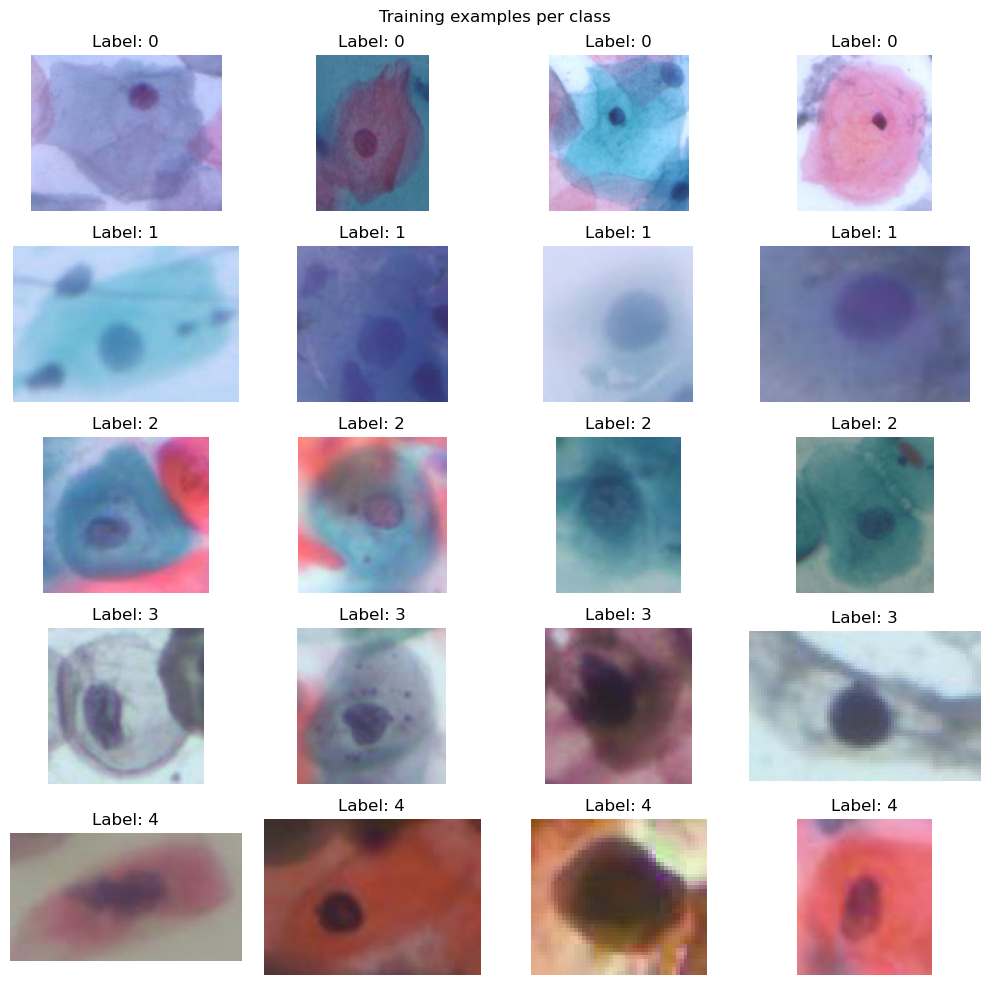

In [57]:
# Visualize some training example
fig, ax = plt.subplots(5, 4, figsize=(10, 10))
for i, idx in enumerate([0, 500, 1000, 1500, 2000]):
    for j in range(4):
        img, label, path = train_loader.dataset[idx+j]
        ax[i,j].imshow(Image.open(os.path.join(data_path, path)))
        ax[i,j].set_title("Label: {}".format(label))
        ax[i,j].axis('off')
# plt.show()
fig.suptitle("Training examples per class")
plt.tight_layout()
    

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [58]:
train_dataset[0][0].shape

torch.Size([2048])

In [70]:
# Implement the model
import torch.nn as nn
import torch.nn.functional as F

embedding_dim = train_dataset.features.shape[1]
model = nn.Linear(embedding_dim, 5)


The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [71]:
# Set the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [61]:
# Set the loss
criterion = F.cross_entropy

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [62]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    ### YOUR CODE
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() * 100 / len(preds)


Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [63]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 
        ### YOUR CODE
        embedding, label, path = batch
        
        # Feed the embeddings to the model
        ### YOUR CODE
        model_output = model(embedding)

        # Compute cross entropy loss
        ### YOUR CODE
        loss = criterion(model_output, label)
        
        # Reset the gradients
        ### YOUR CODE
        optimizer.zero_grad()
        
        # Backpropagate
        ### YOUR CODE
        loss.backward()
        
        # Update the parameters
        ### YOUR CODE
        optimizer.step()
        
        # Store the outputs, labels and loss
        ### YOUR CODE
        full_outputs.append(model_output)
        full_labels.append(label)
        losses.append(loss)

    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    ### YOUR CODE
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [64]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in train mode
    ### YOUR CODE
    model.eval()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        ### YOUR CODE
        embedding, label, path = batch
        
        # Feed the embeddings to the model
        ### YOUR CODE
        model_output = model(embedding)

        # Compute cross entropy loss
        ### YOUR CODE
        loss = criterion(model_output, label)
        
        # Store the outputs, labels and loss
        ### YOUR CODE
        full_outputs.append(model_output)
        full_labels.append(label)
        full_paths.append(path)
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    ### YOUR CODE
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [67]:
np.arange(epochs)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

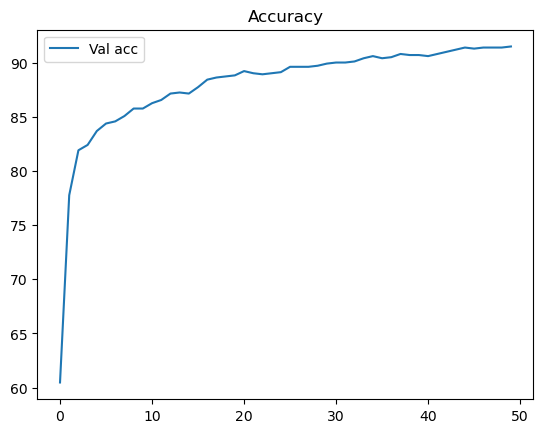

In [72]:
# Main loop
epochs = 50
best_acc = 0
model_savepath = '../data'
accuracies = []

for epoch in range(epochs):
    # Train
    ### YOUR CODE
    train_acc, train_outputs, train_labels, train_loss = train(model, optimizer, criterion, train_loader)

    # Evaluate
    ### YOUR CODE
    val_acc, val_outputs, val_labels, val_loss, val_paths = validate(model, criterion, val_loader)
    accuracies.append(val_acc)

    # Save the model
    if val_acc > best_acc:
        ### YOUR CODE
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(model_savepath, 'model.pth'))
        # print("Model saved! Epoch: {}, Val acc: {:.2f}".format(epoch, val_acc))


plt.plot(np.arange(epochs), accuracies)
plt.legend()
plt.title("Val Accuracy")
plt.show()




### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [159]:
# Re-load the best model
### YOUR CODE
model.load_state_dict(torch.load(os.path.join(model_savepath, 'model.pth')))

# Evaluate
### YOUR CODE
test_acc, test_outputs, test_labels, test_loss, test_paths = validate(model, criterion, test_loader)
print(test_acc)

91.03448275862068


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

In [ ]:
# Display the confusion matrix
### YOUR CODE

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

In [ ]:
# Find the misclassified samples
### YOUR CODE

# Plot the misclassified samples
### YOUR CODE